# IT Academy - Data Science amb Python
## Tasca 7: Estructura de control

###  [Github Registre de Logs](https://github.com/jesussantana/Registre_de_logs)

###  Exercici 1
- Normalitza, identifica i enumera cada un dels atributs / variables de l'estructura de l'arxiu "Web_access_log-akumenius.com" que trobaràs al repositori de GitHub "Data-sources".

In [1]:
import numpy as np
import pandas as pd
import requests
import re
from datetime import datetime

pd.set_option('display.max_columns', None)

In [2]:
path = '../Data/Web_access_log-akumenius.com.txt'

Logs_raw = pd.read_csv(path, sep='\s | \- | \"', names =['DNS','IP','Location','Date','Time','Request','Status','Size','Referer','UserAgent'], skiprows=260771, engine='python')

Logs_copy = Logs_raw.copy()

Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,www.akumenius.com 187.133.87.116,- [02/Mar/2014:00:40:59 +0100],GET /libraries/jqueryui/js/jquery.ui.datepicke...,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...,NaN,NaN,NaN,NaN,NaN
1,www.akumenius.com 187.133.87.116,- [02/Mar/2014:00:41:01 +0100],GET /modules/raton/views/themes/bcoos/js/ga.js...,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...,NaN,NaN,NaN,NaN,NaN
2,www.akumenius.com 187.133.87.116,- [02/Mar/2014:00:40:58 +0100],GET /libraries/jquery/jquery-1.4.2.min.js HTTP...,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...,NaN,NaN,NaN,NaN,NaN
3,www.akumenius.com 187.133.87.116,- [02/Mar/2014:00:41:00 +0100],GET /modules/raton/views/themes/bcoos/js/block...,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...,NaN,NaN,NaN,NaN,NaN
4,www.akumenius.com 187.133.87.116,- [02/Mar/2014:00:41:02 +0100],GET /includes/images/uploaded/logo.png HTTP/1....,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...,NaN,NaN,NaN,NaN,NaN


###  Exercici 2
- Neteja, preprocesa, estructura i transforma (dataframe) les dades del registre d'Accés a la web.

In [3]:
Logs_copy.shape

(1102, 10)

In [4]:
Logs_copy.isnull().sum()

DNS             0
IP              0
Location        0
Date            0
Time            0
Request      1102
Status       1102
Size         1102
Referer      1102
UserAgent    1102
dtype: int64

In [5]:
Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,www.akumenius.com 187.133.87.116,- [02/Mar/2014:00:40:59 +0100],GET /libraries/jqueryui/js/jquery.ui.datepicke...,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...,NaN,NaN,NaN,NaN,NaN
1,www.akumenius.com 187.133.87.116,- [02/Mar/2014:00:41:01 +0100],GET /modules/raton/views/themes/bcoos/js/ga.js...,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...,NaN,NaN,NaN,NaN,NaN
2,www.akumenius.com 187.133.87.116,- [02/Mar/2014:00:40:58 +0100],GET /libraries/jquery/jquery-1.4.2.min.js HTTP...,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...,NaN,NaN,NaN,NaN,NaN
3,www.akumenius.com 187.133.87.116,- [02/Mar/2014:00:41:00 +0100],GET /modules/raton/views/themes/bcoos/js/block...,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...,NaN,NaN,NaN,NaN,NaN
4,www.akumenius.com 187.133.87.116,- [02/Mar/2014:00:41:02 +0100],GET /includes/images/uploaded/logo.png HTTP/1....,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...,NaN,NaN,NaN,NaN,NaN


In [6]:
# Reorder columns of data

Logs_copy.UserAgent = Logs_copy.Time
Logs_copy.Request = Logs_copy.Location
Logs_copy.Referer = Logs_copy.Date
Logs_copy.Date = Logs_copy.IP
Logs_copy.Time = Logs_copy.IP = np.nan
Logs_copy.Location = ""

Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,www.akumenius.com 187.133.87.116,NaN,,- [02/Mar/2014:00:40:59 +0100],NaN,GET /libraries/jqueryui/js/jquery.ui.datepicke...,NaN,NaN,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...
1,www.akumenius.com 187.133.87.116,NaN,,- [02/Mar/2014:00:41:01 +0100],NaN,GET /modules/raton/views/themes/bcoos/js/ga.js...,NaN,NaN,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...
2,www.akumenius.com 187.133.87.116,NaN,,- [02/Mar/2014:00:40:58 +0100],NaN,GET /libraries/jquery/jquery-1.4.2.min.js HTTP...,NaN,NaN,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...
3,www.akumenius.com 187.133.87.116,NaN,,- [02/Mar/2014:00:41:00 +0100],NaN,GET /modules/raton/views/themes/bcoos/js/block...,NaN,NaN,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...
4,www.akumenius.com 187.133.87.116,NaN,,- [02/Mar/2014:00:41:02 +0100],NaN,GET /includes/images/uploaded/logo.png HTTP/1....,NaN,NaN,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...


In [7]:
# DNS & IP data split

Logs_copy[['DNS','IP']] = Logs_copy.DNS.str.split('\s', expand = True).get([0, 1])

In [8]:
Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,www.akumenius.com,187.133.87.116,,- [02/Mar/2014:00:40:59 +0100],NaN,GET /libraries/jqueryui/js/jquery.ui.datepicke...,NaN,NaN,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...
1,www.akumenius.com,187.133.87.116,,- [02/Mar/2014:00:41:01 +0100],NaN,GET /modules/raton/views/themes/bcoos/js/ga.js...,NaN,NaN,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...
2,www.akumenius.com,187.133.87.116,,- [02/Mar/2014:00:40:58 +0100],NaN,GET /libraries/jquery/jquery-1.4.2.min.js HTTP...,NaN,NaN,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...
3,www.akumenius.com,187.133.87.116,,- [02/Mar/2014:00:41:00 +0100],NaN,GET /modules/raton/views/themes/bcoos/js/block...,NaN,NaN,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...
4,www.akumenius.com,187.133.87.116,,- [02/Mar/2014:00:41:02 +0100],NaN,GET /includes/images/uploaded/logo.png HTTP/1....,NaN,NaN,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...


In [9]:
Logs_copy.DNS.unique()

array(['www.akumenius.com', 'localhost', 'akumenius.com',
       'test.akumenius.com', 'akumenius.es'], dtype=object)

In [10]:
# Time data extraction

Logs_copy.Time = Logs_copy.Date.str.extract(':(\d{2}:\d{2}:\d{2}.*)]')

Logs_copy.Time = pd.to_datetime(Logs_copy.Time, format = '%H:%M:%S %z')
Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,www.akumenius.com,187.133.87.116,,- [02/Mar/2014:00:40:59 +0100],1900-01-01 00:40:59+01:00,GET /libraries/jqueryui/js/jquery.ui.datepicke...,NaN,NaN,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...
1,www.akumenius.com,187.133.87.116,,- [02/Mar/2014:00:41:01 +0100],1900-01-01 00:41:01+01:00,GET /modules/raton/views/themes/bcoos/js/ga.js...,NaN,NaN,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...
2,www.akumenius.com,187.133.87.116,,- [02/Mar/2014:00:40:58 +0100],1900-01-01 00:40:58+01:00,GET /libraries/jquery/jquery-1.4.2.min.js HTTP...,NaN,NaN,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...
3,www.akumenius.com,187.133.87.116,,- [02/Mar/2014:00:41:00 +0100],1900-01-01 00:41:00+01:00,GET /modules/raton/views/themes/bcoos/js/block...,NaN,NaN,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...
4,www.akumenius.com,187.133.87.116,,- [02/Mar/2014:00:41:02 +0100],1900-01-01 00:41:02+01:00,GET /includes/images/uploaded/logo.png HTTP/1....,NaN,NaN,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...


In [11]:
# Date data extraction

Logs_copy.Date = Logs_copy.Date.str.extract('(\d+/\w+/\d+)')

Logs_copy.Date = pd.to_datetime(Logs_copy.Date, format = '%d/%b/%Y')

In [12]:
Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,www.akumenius.com,187.133.87.116,,2014-03-02,1900-01-01 00:40:59+01:00,GET /libraries/jqueryui/js/jquery.ui.datepicke...,NaN,NaN,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...
1,www.akumenius.com,187.133.87.116,,2014-03-02,1900-01-01 00:41:01+01:00,GET /modules/raton/views/themes/bcoos/js/ga.js...,NaN,NaN,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...
2,www.akumenius.com,187.133.87.116,,2014-03-02,1900-01-01 00:40:58+01:00,GET /libraries/jquery/jquery-1.4.2.min.js HTTP...,NaN,NaN,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...
3,www.akumenius.com,187.133.87.116,,2014-03-02,1900-01-01 00:41:00+01:00,GET /modules/raton/views/themes/bcoos/js/block...,NaN,NaN,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...
4,www.akumenius.com,187.133.87.116,,2014-03-02,1900-01-01 00:41:02+01:00,GET /includes/images/uploaded/logo.png HTTP/1....,NaN,NaN,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...


In [13]:
# Request & Status data split

Logs_copy[['Request','Status']] = Logs_copy.Request.str.split('\"', expand = True).get([0, 1])

In [14]:
Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,www.akumenius.com,187.133.87.116,,2014-03-02,1900-01-01 00:40:59+01:00,GET /libraries/jqueryui/js/jquery.ui.datepicke...,200 36542,NaN,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...
1,www.akumenius.com,187.133.87.116,,2014-03-02,1900-01-01 00:41:01+01:00,GET /modules/raton/views/themes/bcoos/js/ga.js...,200 419,NaN,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...
2,www.akumenius.com,187.133.87.116,,2014-03-02,1900-01-01 00:40:58+01:00,GET /libraries/jquery/jquery-1.4.2.min.js HTTP...,200 72174,NaN,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...
3,www.akumenius.com,187.133.87.116,,2014-03-02,1900-01-01 00:41:00+01:00,GET /modules/raton/views/themes/bcoos/js/block...,200 28568,NaN,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...
4,www.akumenius.com,187.133.87.116,,2014-03-02,1900-01-01 00:41:02+01:00,GET /includes/images/uploaded/logo.png HTTP/1.1,200 11389,NaN,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...


In [15]:
# Size data extraction

Logs_copy.Size = Logs_copy.Status.str.extract('(\d+$)')
Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,www.akumenius.com,187.133.87.116,,2014-03-02,1900-01-01 00:40:59+01:00,GET /libraries/jqueryui/js/jquery.ui.datepicke...,200 36542,36542,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...
1,www.akumenius.com,187.133.87.116,,2014-03-02,1900-01-01 00:41:01+01:00,GET /modules/raton/views/themes/bcoos/js/ga.js...,200 419,419,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...
2,www.akumenius.com,187.133.87.116,,2014-03-02,1900-01-01 00:40:58+01:00,GET /libraries/jquery/jquery-1.4.2.min.js HTTP...,200 72174,72174,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...
3,www.akumenius.com,187.133.87.116,,2014-03-02,1900-01-01 00:41:00+01:00,GET /modules/raton/views/themes/bcoos/js/block...,200 28568,28568,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...
4,www.akumenius.com,187.133.87.116,,2014-03-02,1900-01-01 00:41:02+01:00,GET /includes/images/uploaded/logo.png HTTP/1.1,200 11389,11389,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...


In [16]:
# Status data extraction

Logs_copy.Status = Logs_copy.Status.str.extract('(\d{3})')
Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,www.akumenius.com,187.133.87.116,,2014-03-02,1900-01-01 00:40:59+01:00,GET /libraries/jqueryui/js/jquery.ui.datepicke...,200,36542,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...
1,www.akumenius.com,187.133.87.116,,2014-03-02,1900-01-01 00:41:01+01:00,GET /modules/raton/views/themes/bcoos/js/ga.js...,200,419,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...
2,www.akumenius.com,187.133.87.116,,2014-03-02,1900-01-01 00:40:58+01:00,GET /libraries/jquery/jquery-1.4.2.min.js HTTP...,200,72174,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...
3,www.akumenius.com,187.133.87.116,,2014-03-02,1900-01-01 00:41:00+01:00,GET /modules/raton/views/themes/bcoos/js/block...,200,28568,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...
4,www.akumenius.com,187.133.87.116,,2014-03-02,1900-01-01 00:41:02+01:00,GET /includes/images/uploaded/logo.png HTTP/1.1,200,11389,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...


In [17]:
# Referer useless data correction
for index, row in Logs_copy.iterrows(): 
    
    if '-"' in row.Referer:
        row.Referer = ""
                
Logs_copy  

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,www.akumenius.com,187.133.87.116,,2014-03-02,1900-01-01 00:40:59+01:00,GET /libraries/jqueryui/js/jquery.ui.datepicke...,200,36542,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...
1,www.akumenius.com,187.133.87.116,,2014-03-02,1900-01-01 00:41:01+01:00,GET /modules/raton/views/themes/bcoos/js/ga.js...,200,419,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...
2,www.akumenius.com,187.133.87.116,,2014-03-02,1900-01-01 00:40:58+01:00,GET /libraries/jquery/jquery-1.4.2.min.js HTTP...,200,72174,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...
3,www.akumenius.com,187.133.87.116,,2014-03-02,1900-01-01 00:41:00+01:00,GET /modules/raton/views/themes/bcoos/js/block...,200,28568,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...
4,www.akumenius.com,187.133.87.116,,2014-03-02,1900-01-01 00:41:02+01:00,GET /includes/images/uploaded/logo.png HTTP/1.1,200,11389,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...
...,...,...,...,...,...,...,...,...,...,...
1097,www.akumenius.com,5.255.253.53,,2014-03-02,1900-01-01 03:05:39+01:00,GET / HTTP/1.1,200,7528,"-""",Mozilla/5.0 (compatible; YandexBot/3.0; +http:...
1098,www.akumenius.com,74.86.158.107,,2014-03-02,1900-01-01 03:09:52+01:00,HEAD / HTTP/1.1,200,200,"""-""",Mozilla/5.0+(compatible; UptimeRobot/2.0; http...
1099,localhost,127.0.0.1,,2014-03-02,1900-01-01 03:10:18+01:00,OPTIONS * HTTP/1.0,200,200,"""-""","Apache (internal dummy connection)"" VLOG=-"
1100,localhost,127.0.0.1,,2014-03-02,1900-01-01 03:10:18+01:00,OPTIONS * HTTP/1.0,200,200,"""-""","Apache (internal dummy connection)"" VLOG=-"


In [18]:
    
for index, row in Logs_copy.iterrows(): 
    
    if re.search('.*[^\"]', row.Referer):

        row.Referer = ""

In [19]:
Logs_copy

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,www.akumenius.com,187.133.87.116,,2014-03-02,1900-01-01 00:40:59+01:00,GET /libraries/jqueryui/js/jquery.ui.datepicke...,200,36542,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...
1,www.akumenius.com,187.133.87.116,,2014-03-02,1900-01-01 00:41:01+01:00,GET /modules/raton/views/themes/bcoos/js/ga.js...,200,419,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...
2,www.akumenius.com,187.133.87.116,,2014-03-02,1900-01-01 00:40:58+01:00,GET /libraries/jquery/jquery-1.4.2.min.js HTTP...,200,72174,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...
3,www.akumenius.com,187.133.87.116,,2014-03-02,1900-01-01 00:41:00+01:00,GET /modules/raton/views/themes/bcoos/js/block...,200,28568,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...
4,www.akumenius.com,187.133.87.116,,2014-03-02,1900-01-01 00:41:02+01:00,GET /includes/images/uploaded/logo.png HTTP/1.1,200,11389,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...
...,...,...,...,...,...,...,...,...,...,...
1097,www.akumenius.com,5.255.253.53,,2014-03-02,1900-01-01 03:05:39+01:00,GET / HTTP/1.1,200,7528,"-""",Mozilla/5.0 (compatible; YandexBot/3.0; +http:...
1098,www.akumenius.com,74.86.158.107,,2014-03-02,1900-01-01 03:09:52+01:00,HEAD / HTTP/1.1,200,200,"""-""",Mozilla/5.0+(compatible; UptimeRobot/2.0; http...
1099,localhost,127.0.0.1,,2014-03-02,1900-01-01 03:10:18+01:00,OPTIONS * HTTP/1.0,200,200,"""-""","Apache (internal dummy connection)"" VLOG=-"
1100,localhost,127.0.0.1,,2014-03-02,1900-01-01 03:10:18+01:00,OPTIONS * HTTP/1.0,200,200,"""-""","Apache (internal dummy connection)"" VLOG=-"


###  Exercici 3
- Geolocalitza les IP's. Aqui tens una pagina de interes:
  - [IP2Locattion](https://blog.ip2location.com/knowledge-base/how-to-add-a-sub-account-in-ip2location/)

In [20]:
import json
from ip2geotools.databases.noncommercial import DbIpCity

In [21]:
# Extract Ips

ips = Logs_copy.IP.unique()
ips

array(['187.133.87.116', '66.249.76.216', '217.12.28.5', '127.0.0.1',
       '74.86.158.107', '220.181.108.115', '157.56.93.103',
       '157.55.35.41', '212.231.208.21', '74.86.158.106', '123.125.71.31',
       '69.171.229.117', '69.171.229.119', '69.171.229.114',
       '69.171.229.118', '69.171.229.112', '173.252.77.116',
       '173.252.77.117', '173.252.77.118', '173.252.77.119',
       '173.252.77.113', '173.252.77.114', '176.31.255.177',
       '88.20.52.218', '199.30.20.35', '157.55.32.185', '181.164.57.183',
       '180.76.5.114', '217.12.28.130', '31.4.208.178', '87.217.147.158',
       '157.56.93.82', '201.31.227.195', '89.107.180.75', '157.55.34.176',
       '157.55.33.78', '199.30.20.66', '174.129.237.157', '123.125.71.17',
       '220.181.108.89', '201.134.106.130', '180.76.5.119',
       '180.76.6.155', '180.76.5.28', '202.46.58.28', '119.63.193.130',
       '180.76.6.132', '93.186.202.198', '180.76.5.95', '194.224.196.204',
       '83.63.131.193', '46.222.83.180', '79.1

In [22]:
# Function for extract Locations

localhost = "127.0.0.1"

def extract_location(ip):
    
    try:
        if ip == localhost:
            return ('Local', 'Local')

        else:
            response = DbIpCity.get(ip, api_key = 'free').to_json()    
            data = json.loads(response)
            return data['city'], data['country']
    
    except:
        return np.nan

In [23]:
# Extract Location Test

extract_location(Logs_copy.IP[50])

nan

In [24]:
# List of locations for unique Ips

locations = []

for item in ips:
    
    locations.append(extract_location(item))  

locations

[nan,
 nan,
 nan,
 ('Local', 'Local'),
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [25]:
# Compare ips & add location

for index, row in Logs_copy.iterrows():
    
    # iterate the two lists
    for a, b in zip(ips, locations):
        
        # Compare & add
        if row.IP == a:
            row.Location = b

In [26]:
Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,www.akumenius.com,187.133.87.116,,2014-03-02,1900-01-01 00:40:59+01:00,GET /libraries/jqueryui/js/jquery.ui.datepicke...,200,36542,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...
1,www.akumenius.com,187.133.87.116,,2014-03-02,1900-01-01 00:41:01+01:00,GET /modules/raton/views/themes/bcoos/js/ga.js...,200,419,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...
2,www.akumenius.com,187.133.87.116,,2014-03-02,1900-01-01 00:40:58+01:00,GET /libraries/jquery/jquery-1.4.2.min.js HTTP...,200,72174,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...
3,www.akumenius.com,187.133.87.116,,2014-03-02,1900-01-01 00:41:00+01:00,GET /modules/raton/views/themes/bcoos/js/block...,200,28568,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...
4,www.akumenius.com,187.133.87.116,,2014-03-02,1900-01-01 00:41:02+01:00,GET /includes/images/uploaded/logo.png HTTP/1.1,200,11389,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...


In [27]:
# Extract UserAgent Data

from device_detector import SoftwareDetector

Devices = Logs_copy['UserAgent']
device = []

for x in Devices:
    
    device.append(SoftwareDetector(x).parse())

client_name = []
client_type = []
client_version = []
os_name = []
os_version = []
device_type = []

for x in device:
    
    client_name.append(x.client_name())
    client_type.append(x.client_type())
    client_version.append(x.client_version())
    os_name.append(x.os_name())
    os_version.append(x.os_version())
    device_type.append(x.device_type())

Logs_copy['Client Name'] = client_name
Logs_copy['Client Type'] = client_type
Logs_copy['Client Version'] = client_version
Logs_copy['Os Name'] = os_name
Logs_copy['Os Version'] = os_version
Logs_copy['Device Type'] = device_type

Logs_copy

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent,Client Name,Client Type,Client Version,Os Name,Os Version,Device Type
0,www.akumenius.com,187.133.87.116,,2014-03-02,1900-01-01 00:40:59+01:00,GET /libraries/jqueryui/js/jquery.ui.datepicke...,200,36542,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...,Android Browser,browser,,Android,4.0.4,
1,www.akumenius.com,187.133.87.116,,2014-03-02,1900-01-01 00:41:01+01:00,GET /modules/raton/views/themes/bcoos/js/ga.js...,200,419,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...,Android Browser,browser,,Android,4.0.4,
2,www.akumenius.com,187.133.87.116,,2014-03-02,1900-01-01 00:40:58+01:00,GET /libraries/jquery/jquery-1.4.2.min.js HTTP...,200,72174,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...,Android Browser,browser,,Android,4.0.4,
3,www.akumenius.com,187.133.87.116,,2014-03-02,1900-01-01 00:41:00+01:00,GET /modules/raton/views/themes/bcoos/js/block...,200,28568,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...,Android Browser,browser,,Android,4.0.4,
4,www.akumenius.com,187.133.87.116,,2014-03-02,1900-01-01 00:41:02+01:00,GET /includes/images/uploaded/logo.png HTTP/1.1,200,11389,http://www.akumenius.com/hoteles-baratos/hotel...,Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; S...,Android Browser,browser,,Android,4.0.4,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1097,www.akumenius.com,5.255.253.53,,2014-03-02,1900-01-01 03:05:39+01:00,GET / HTTP/1.1,200,7528,"-""",Mozilla/5.0 (compatible; YandexBot/3.0; +http:...,YandexBot,generic,3.0,,,
1098,www.akumenius.com,74.86.158.107,,2014-03-02,1900-01-01 03:09:52+01:00,HEAD / HTTP/1.1,200,200,"""-""",Mozilla/5.0+(compatible; UptimeRobot/2.0; http...,UptimeRobot,generic,2.0,,,
1099,localhost,127.0.0.1,,2014-03-02,1900-01-01 03:10:18+01:00,OPTIONS * HTTP/1.0,200,200,"""-""","Apache (internal dummy connection)"" VLOG=-","Apache (internal dummy connection)"" VLOG=-",generic,None,,,
1100,localhost,127.0.0.1,,2014-03-02,1900-01-01 03:10:18+01:00,OPTIONS * HTTP/1.0,200,200,"""-""","Apache (internal dummy connection)"" VLOG=-","Apache (internal dummy connection)"" VLOG=-",generic,None,,,


In [28]:
Logs_copy.UserAgent[0]

'Mozilla/5.0 (Linux; U; Android 4.0.4; es-mx; SonyEricssonST15i Build/4.1.B.0.587) AppleWebKit/534.30 (KHTML, like Gecko) Version/4.0 Mobile Safari/534.30" VLOG=-'

In [29]:
del(Logs_copy['UserAgent'])

Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,Client Name,Client Type,Client Version,Os Name,Os Version,Device Type
0,www.akumenius.com,187.133.87.116,,2014-03-02,1900-01-01 00:40:59+01:00,GET /libraries/jqueryui/js/jquery.ui.datepicke...,200,36542,http://www.akumenius.com/hoteles-baratos/hotel...,Android Browser,browser,,Android,4.0.4,
1,www.akumenius.com,187.133.87.116,,2014-03-02,1900-01-01 00:41:01+01:00,GET /modules/raton/views/themes/bcoos/js/ga.js...,200,419,http://www.akumenius.com/hoteles-baratos/hotel...,Android Browser,browser,,Android,4.0.4,
2,www.akumenius.com,187.133.87.116,,2014-03-02,1900-01-01 00:40:58+01:00,GET /libraries/jquery/jquery-1.4.2.min.js HTTP...,200,72174,http://www.akumenius.com/hoteles-baratos/hotel...,Android Browser,browser,,Android,4.0.4,
3,www.akumenius.com,187.133.87.116,,2014-03-02,1900-01-01 00:41:00+01:00,GET /modules/raton/views/themes/bcoos/js/block...,200,28568,http://www.akumenius.com/hoteles-baratos/hotel...,Android Browser,browser,,Android,4.0.4,
4,www.akumenius.com,187.133.87.116,,2014-03-02,1900-01-01 00:41:02+01:00,GET /includes/images/uploaded/logo.png HTTP/1.1,200,11389,http://www.akumenius.com/hoteles-baratos/hotel...,Android Browser,browser,,Android,4.0.4,


###  Exercici 4
- Mostreu-me la teva creativitat, Sorprèn-me fes un pas més enllà amb el analysis anterior.

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<AxesSubplot:>

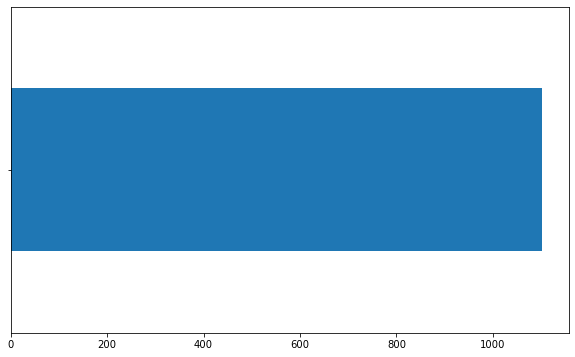

In [31]:

Logs_copy.Location.value_counts(ascending = True).plot(kind = 'barh', figsize = (10,6))

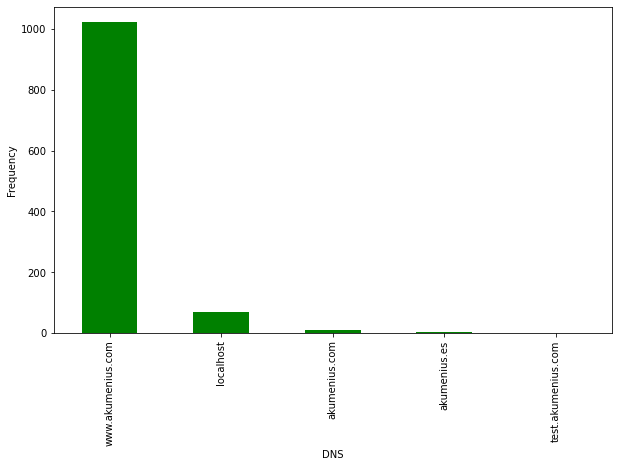

In [32]:
graph = Logs_copy[['DNS', 'Location']].groupby(['DNS']).count().sort_values(by = 'Location',ascending = False)
graph = graph.rename(columns = {'Location' : 'Frequency'})
graph.plot.bar(y = 'Frequency', color = 'g', ylabel = 'Frequency', legend = None, figsize = (10,6))
plt.show()

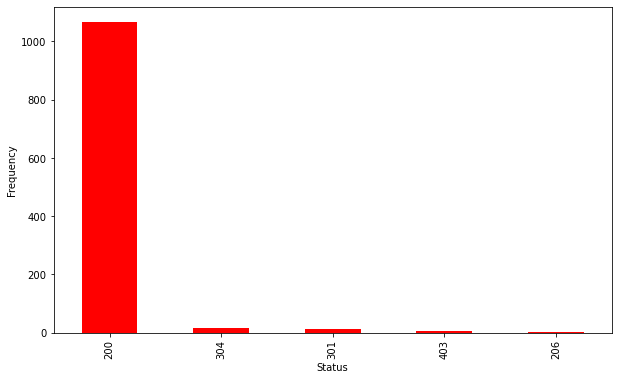

In [33]:
graph = Logs_copy[['Status', 'Date']].groupby(['Status']).count().sort_values(by = 'Date',ascending = False)
graph = graph.rename(columns = {'Date' : 'Frequency'})
graph.plot.bar(y = 'Frequency', color = 'r', ylabel = 'Frequency', legend = None, figsize = (10,6))
plt.show()

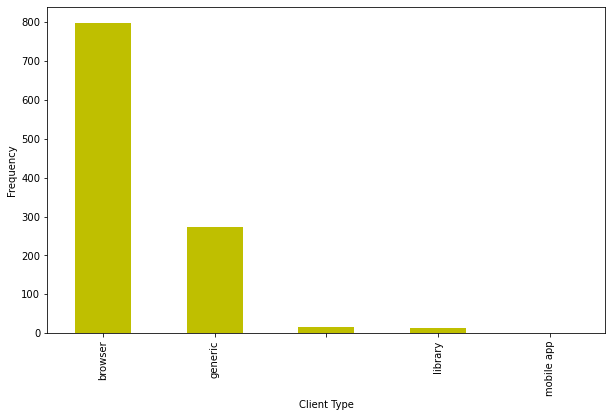

In [34]:
graph = Logs_copy[['Client Type', 'Date']].groupby(['Client Type']).count().sort_values(by = 'Date',ascending = False)
graph = graph.rename(columns = {'Date' : 'Frequency'})
graph.plot.bar(y = 'Frequency', color = 'y', ylabel = 'Frequency', legend = None, figsize = (10,6))
plt.show()

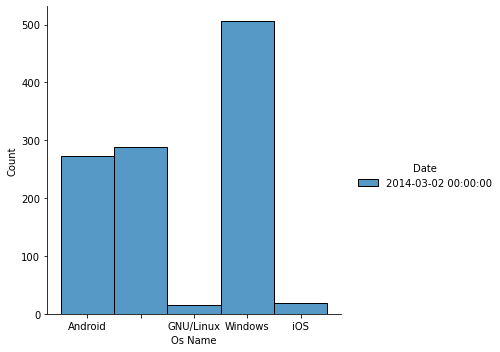

In [35]:
sns.displot(data = Logs_copy, x = "Os Name", hue = "Date", multiple = "stack")

In [36]:
Logs_export = Logs_copy.copy()

Logs_export.replace('', 'null', inplace = True)

Logs_export.to_csv('../Data/Logs_export.csv', index = False)